[View in Colaboratory](https://colab.research.google.com/github/SwapnilSParkhe/FAST_AI/blob/master/FASTAI_Lesson1.ipynb)

#Fast.ai Course  
## Lesson-1: Image Classification - Cats Vs Dogs

### Step-0: Calibrate platforms (Setting-up compatibile interface btwn Colab & fast.ai) 

Note: Run for each unique instance of connection 

**Imp: Check if GPU running and what % of GPU is available (>500MB RAM worked)**

In [3]:
#Check if GPU running
import tensorflow as tf
print(tf.test.gpu_device_name())

#Libraries and code to check % GPU free for you for this runtime
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
#FACT: Only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

/device:GPU:0
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
plotnine 0.3.0 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
Gen RAM Free: 12.0 GB  | Proc size: 1.1 GB
GPU RAM Free: 564MB | Used: 10875MB | Util  95% | Total 11439MB


**Installing required and dependent libraries on Colab for fast.ai**

In [0]:
#FASTAI lib (use this to remove '!rm -rf fastai')
!pip install fastai

#FASTAI dependencies - LibSim lib (Pytorch installed below)
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

#IMPORTANT STUFF - to enable smooth runs without memory issues
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

#Others libs like Pillow, PIL, Image, cv2 - For image data wrangling
!pip install Pillow==4.0.0
!pip install image
import cv2

### Step-1: Importing relevant libraries and modules for analysis

In [0]:
#Library and modules
from fastai.imports import *   #main library
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

#To get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Step-2: Download dataset

In [0]:
#Making directory 'data' -> getting our data from the web -> unzipping zipped data to 'data' dir
!mkdir data && wget http://files.fast.ai/data/dogscats.zip && unzip dogscats.zip -d data/

### Step-3: Inspect data (and wrangle if required)

**Checking Directory Contents**

In [4]:
#Defining the sub-dir path
PATH = "data/dogscats"

#What folders/files do we have in sub-dir
!ls {PATH}
!ls {PATH}/valid
files = !ls {PATH}/valid/cats | head
files

models	sample	test1  tmp  train  valid
cats  dogs


['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

**Checking some data**

(299, 341, 3)

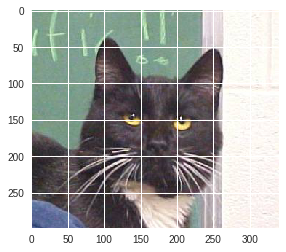

In [5]:
#Using plt's commands to read (path) and show image
##Note: Using Python string formating options f'{python_objects_or_funtions}'
img=plt.imread(f'{PATH}/valid/cats/{files[8]}')
plt.imshow(img)

#Dimensions of image - height vs width
img.shape

**Importing data and creating data-model pipeline**

In [0]:
#Creating an image classifier data object using a fastai defined class (that points to folder having images and in parallel applying transformations)
data=ImageClassifierData.from_paths(path=PATH, bs=24, tfms=tfms_from_model(resnet34,224))  


### Step-4: Train Model 
Note: 
  1. First, using transfer learning to leverage a pre-trained 'resnet34' model to train last layer (now with 2 classes instead of 1000) keeping other layers frozen
  2. Later, we could fine tune the pre-trained model completely (unfreezing other layers) to achieve better results

In [15]:
#Creating a learner object using a fastai defined class (that leverages predefined convnet models)
##Note: precompute=True caches second last layer activations for our existing training data (and not augmented data)
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

#Fitting the learner object on training data to train last layer FC of 2 classes (having learning rate and epochs as arguments)
learn.fit(0.01,3)

epoch      trn_loss   val_loss   accuracy   
    0      0.067113   0.034496   0.989     
 21%|██▏       | 204/959 [00:03<00:12, 60.53it/s, loss=0.0567]

    1      0.064627   0.026704   0.9905    
 44%|████▎     | 419/959 [00:06<00:08, 62.59it/s, loss=0.0621]

    2      0.04997    0.035225   0.987     


[array([0.03522]), 0.9869999952316284]

### Step-5: Analytise Results (to see where we failed, & focus there to further improve)
Note: As well as looking at the overall metrics and Confusion Matrix, looking at examples of each of:

  1. A few correct labels at random (TP, TN)
  2. A few incorrect labels at random (FN, FP)
  3. The most correct labels of each class (High prob of TP and TN)
  4. The most incorrect labels of each class (High prob of FP and FN)
  5. The most uncertain labels (0.5 prob of TP or FP, and TN or FN)

**Confusion Matrix**

[0 0 0 ... 1 1 1]
['cats', 'dogs'] 

[[ -0.10383  -2.31648]
 [ -0.00006  -9.78887]
 [ -0.00696  -4.97044]
 ...
 [-10.03549  -0.00004]
 [-10.11336  -0.00004]
 [ -6.51549  -0.00148]]
(2000, 2) 

[[992   8]
 [ 17 983]]


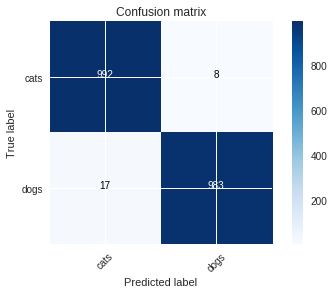

In [16]:
#Predicitons' Key (Actual 0 means cats, and vice-versa)
print(data.val_y)
print(data.classes,'\n')

#Prediction (Note: by default they are log preds in PyTorch)
log_preds=learn.predict()
print(log_preds)
print(log_preds.shape,'\n')

#Inputs for Conf Mat
preds=np.argmax(log_preds, axis=1)  #class with max prob
probs=np.exp(log_preds[:,1])  #prob fr class of interest '1'

#Getting COnf Mat
cm=confusion_matrix(y,preds)
plot_confusion_matrix(cm, data.classes)

**Looking at some pictures and predictions!**

In [0]:
#Utility functions to analyse and visualise results
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)
  
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+'/'+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))
  
  
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Correctly classified


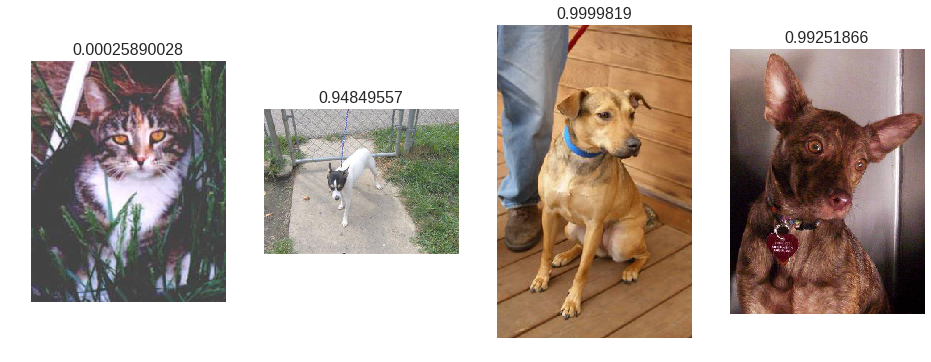

In [17]:
#1.A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


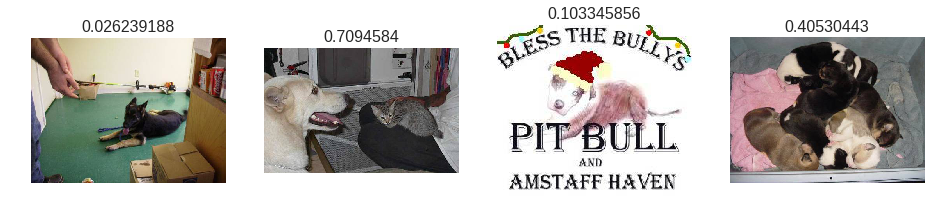

In [19]:
#2.A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Analysis (incorrect labels at random):
  - Not actually any animal w.r.t training
  - Too small image may be (creating an illusion)
  - Two distinct animals (class of interest is there, although on left whereas cat is at center)
  - Multiple figures creating an illusion may be, and class figure is too small

Most correct cats
Most correct dogs


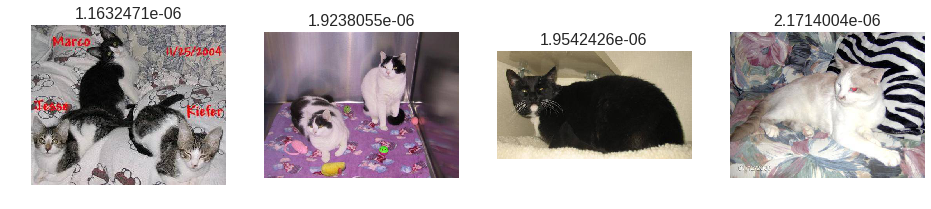

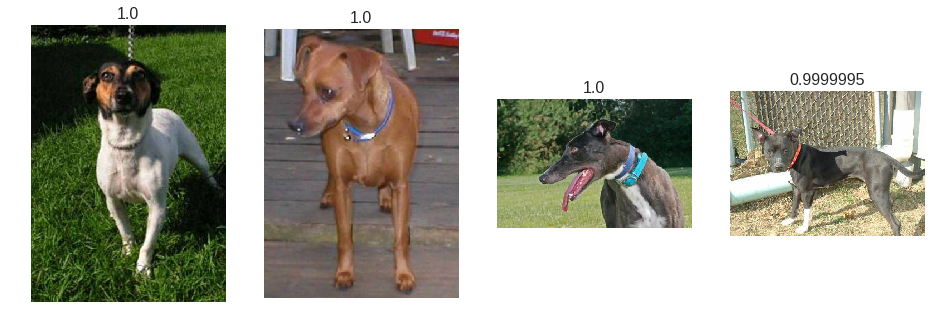

In [20]:
#3.Most Correct of each class
plot_val_with_title(most_by_correct(0, True), "Most correct cats")
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Analysis (most correct):
  - Class(s) usually lie at center
  - Class dominates major portion of image
  - Multiple elements of same class perform well
  - Optimal size of class element

Most incorrect cats
Most incorrect dogs


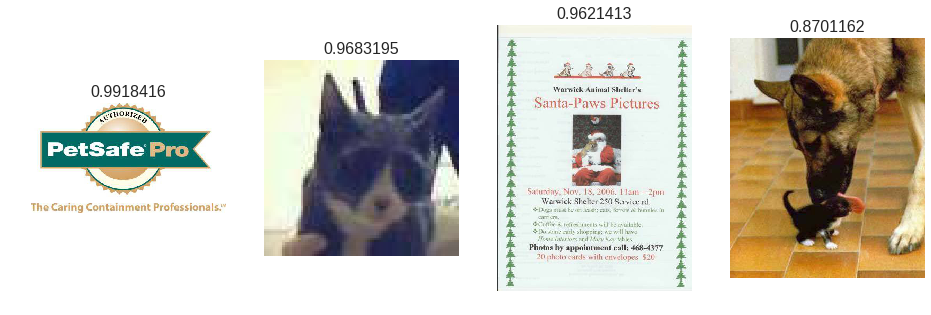

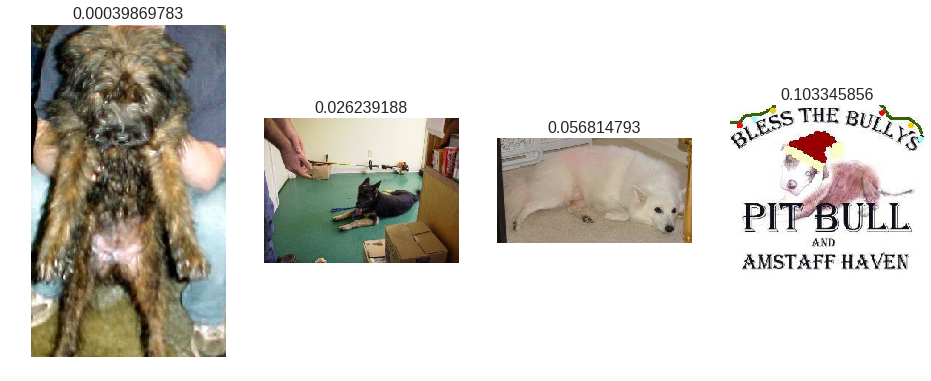

In [21]:
#4.Most Incorrect of each class
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Analysis (most incorrect):
  - Definately not any class
  - Pixels or image quality too bad
  - Multiple classes (not trained upon)
  - Zoomed in, Too wide or long images

Most uncertain predictions


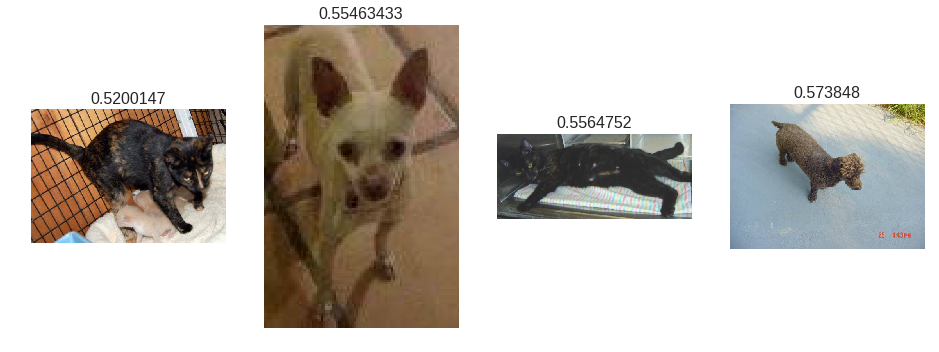

In [22]:
#5.Most uncertain
plot_val_with_title(np.argsort(np.abs(probs -0.5))[:4], "Most uncertain predictions")

Analysis:
  - Too long or wide (center of image must be well-defined)
  - Blurry and not relevant image
  - Multiple classes (of non-relevance)
  - Multiple classes of relevance but spread out (nothing at center)

### Step-6: Tuning Model

**1) Data Augmentation**

Note:
  - Why? As we train for more epochs, we might overfit
  - Fix? Change images s.t. context is till same (flip, zoom, rotate - data dependent)

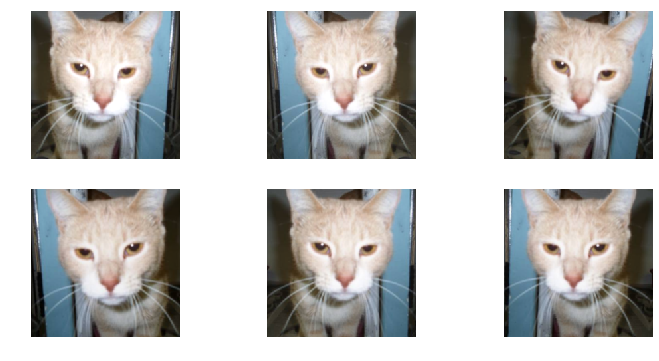

In [3]:
#Defining data augmentation methods via transformations 
tfms_da=tfms_from_model(resnet34, 224, aug_tfms=transforms_side_on, max_zoom=1.1)

#Checking how data augmentation would look like
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms_da, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]
  
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [0]:
#New data object with data augmentation
data=ImageClassifierData.from_paths(PATH,bs=24, tfms=tfms_da)

#Creating learner object for further steps
##Note: precompute=True is using the cached activations of second last layer for existing training data and NOT augmented (from earlier step)
learn=ConvLearner.pretrained(resnet34, data, precompute=True)

**Training LAST LAYER of Model first (finding 'lr' and optimizing training)**

Note: 
  1. First, we **find an descent learning rate** to start with (it's NOT optimal or final) - based on "Cyclical Learning Rates for Training Neural Networks" paper, where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing
  2. Second, we **optimize training process** using SGDR approaches (cyclic LR and scheduled cyclic LR) starting with the found descent lr then annealing and cycling -  helpful to find parts of the parameter space that are both accurate and stable

 69%|██████▉   | 662/959 [00:10<00:04, 63.65it/s, loss=0.35]

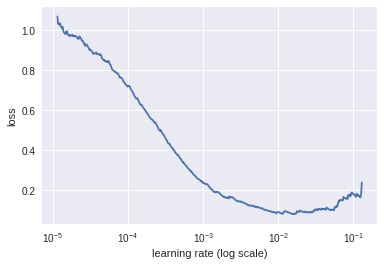

In [9]:
#1.Finding a decent learning rate to train learned object
lrf=learn.lr_find()
learn.sched.plot()

Observation: 
  1. We don't choose 0.1 (lr for lowest loss) but rather 0.01 as the loss is still improving (0.1 would be a bit aggressive and might lead to divergence)
  2. Optimal learning rate can change as we train the model, so you may want to re-run this function from time to time

In [6]:
#Training with the found out descent 'lr' (NOT the final lr)
##Note: Fitting the learner object on training data to train last layer FC of 2 classes (having learning rate and epochs as arguments), but this is not right as we have not utilised our augmented data as precomputed activations are just for existig non-aug training data
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy   
    0      0.071932   0.02491    0.993     



[array([0.02491]), 0.9929999973773956]

In [0]:
#To utilise augmentated data for training, turn off precompute so that we dont use previously calculated activations BUT now rather re-compute activations for all data (aug + non-aug)
learn.precompute=False

epoch      trn_loss   val_loss   accuracy   
    0      0.056636   0.025696   0.989     
 35%|███▍      | 331/959 [01:14<02:22,  4.42it/s, loss=0.0622]

    1      0.059519   0.027101   0.9885    
 11%|█         | 105/959 [00:25<03:24,  4.17it/s, loss=0.0565]

    2      0.05993    0.024765   0.9895    


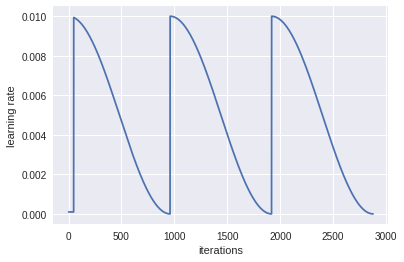

In [11]:
#2a.Optimizing training process for last layer cyclic LR SGDR
##Note: cycle_len is no. of epochs between consecutive restarts
learn.fit(1e-02, 3, cycle_len=1)
learn.sched.plot_lr()

Stopping criteria for our tuned final layer of NN:
  1. Accuracy is almost constant now
  2. Training and validation losses are not improving much and comparable 

In [0]:
#Saving and Loading tuned final layer model
learn.save('224_lastlayer')
learn.load('224_lastlayer')

**2) Finetuning INETRMEDIATE LAYERs (finding 'lr' and optimizing training)**

Note:
  - Unfreeze all layers first groups
  - Use LR finder to find LR for last layer again!
  - Apply differential learning rate to tune other layers (since this data is similar to ImageNet data, we don't need to tune layers much and thus keep a low learning rate s.t. intial few layers don't change much - very low lr or differnece of 10x for consectuive layers)

In [0]:
#CALIBRATION
#New data object with data augmentation
data=ImageClassifierData.from_paths(PATH,bs=32, tfms=tfms_da)

#Creating learner object for further steps
learn=ConvLearner.pretrained(resnet34, data, precompute=True)

#Turn off precompute as for augmentated data, these activations wont work
learn.precompute=False

epoch      trn_loss   val_loss   accuracy   
    0      0.05085    0.024691   0.9905    
  5%|▌         | 38/719 [00:24<07:14,  1.57it/s, loss=0.0573]

    1      0.04852    0.018092   0.9915    
 10%|█         | 74/719 [00:42<06:12,  1.73it/s, loss=0.0391]

    2      0.042677   0.017324   0.994     
 13%|█▎        | 95/719 [00:56<06:11,  1.68it/s, loss=0.0483]

    3      0.035134   0.029126   0.9905    
 15%|█▍        | 107/719 [01:04<06:09,  1.65it/s, loss=0.0331]

    4      0.019593   0.02177    0.9905    
 16%|█▌        | 114/719 [01:08<06:05,  1.66it/s, loss=0.0205]

    5      0.024263   0.024621   0.9895    
 16%|█▋        | 118/719 [01:10<05:59,  1.67it/s, loss=0.0215]

    6      0.017693   0.020944   0.9925    


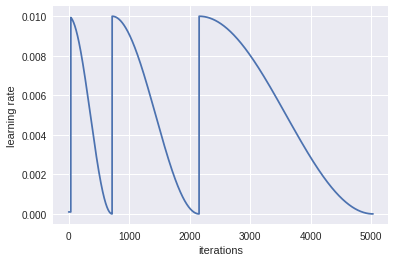

In [9]:
#1.Unfreeze all layers
learn.unfreeze()

#2&3.Differential learning rates (last layer would have 'lr' finder lr)
lr=np.array([1e-4, 1e-3, 1e-2])

#Optimizing training process for unfrozen model with schedule cyclic LR SGDR
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_lr()


### Step-7: Saving Model and Predicting Smartly
**Saving tuned model**

In [0]:
#Saving and loading final tuned model
learn.save('224_all')
learn.load('224_all')

**Test time Augmentation (TTA) using tuned model**

Note:
  - What: More of an approach to help model see different versions of image and get the most out of the images which might not be so good images!!
  - Makes predictions not just on the images in your validation (and test) set, but also makes predictions on a number of randomly augmented versions of them too; Then takes the average prediction from these images, and uses that

In [11]:
#Applying TTA (outputs log_preds and y)
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.993

### Step-8: Analyzing results again!

**Confusion Matrix**

[[989  11]
 [  3 997]]


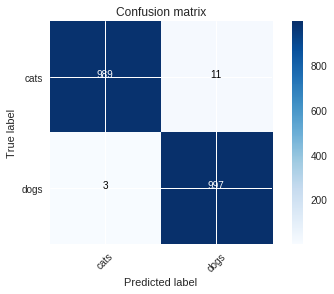

In [12]:
#Inputs for COnf mat
preds=np.argmax(probs, axis=1)  #class with max prob
probs=probs[:,1]  #prob for class of interest '1'

#Getting COnf Mat
cm=confusion_matrix(y,preds)
plot_confusion_matrix(cm, data.classes)

### Step-9: Further Imporving Model (Using more sophisticated architectures)

**Naive Model**

In [5]:
#Running a naive model without tuning much to see how default model performs
data=ImageClassifierData.from_paths(path=PATH,bs=16,tfms=tfms_from_model(resnet50,224),num_workers=4)
learner=ConvLearner.pretrained(resnet50,data=data,precompute=True,ps=0.5)

100%|██████████| 125/125 [00:21<00:00,  5.85it/s]


 65%|██████▌   | 938/1438 [00:16<00:08, 58.31it/s, loss=0.282]

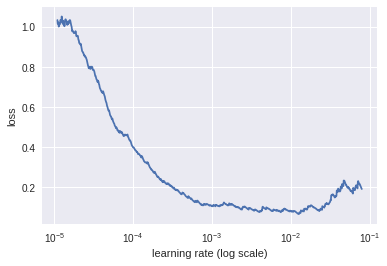

In [7]:
#Find the descent lr to start with
learner.lr_find()
learner.sched.plot()

In [9]:
#Checking fit with descent lr (then deciding if we need to tune more)
learner.fit(0.001,3)

epoch      trn_loss   val_loss   accuracy   
    0      0.061588   0.029268   0.9895    
 40%|████      | 581/1438 [00:10<00:15, 56.57it/s, loss=0.0528]

    1      0.058142   0.025669   0.9905    
 23%|██▎       | 324/1438 [00:06<00:21, 51.60it/s, loss=0.081]

    2      0.10159    0.028206   0.9895    


[array([0.02821]), 0.9895]

**Tuning Model :**
  1. DataAugmentation-SGDR (Just Last Layer first)
  2. FineTuning-SGDR (Intermediate Layers)

In [0]:
#1.DataAugmentation (and LR-finder)
tfms_da=tfms_from_model(resnet50,sz=224,aug_tfms=transforms_side_on,max_zoom=1.1)
data=ImageClassifierData.from_paths(path=PATH,bs=16,tfms=tfms_da,num_workers=4)
learner=ConvLearner.pretrained(resnet50,data=data,precompute=False,ps=0.5)

 64%|██████▍   | 923/1438 [03:06<01:43,  4.96it/s, loss=0.318]

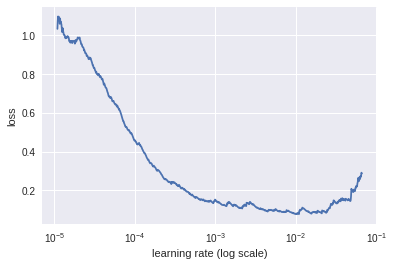

In [11]:
#LR-finder (Doesnt change much)
learner.lr_find()
learner.sched.plot()

In [12]:
#SGDR
learner.fit(0.001,3,cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.073765   0.028102   0.9895    
 23%|██▎       | 329/1438 [00:57<03:14,  5.71it/s, loss=0.0549]

    1      0.057318   0.026937   0.9905    
  0%|          | 0/1438 [00:00<?, ?it/s, loss=0.0567]

    2      0.08403    0.038644   0.988     


[array([0.03864]), 0.988]

In [0]:
#2.Finetuning Layers
tfms_da=tfms_from_model(resnet50,sz=224,aug_tfms=transforms_side_on,max_zoom=1.1)
data=ImageClassifierData.from_paths(path=PATH,bs=4,tfms=tfms_da,num_workers=4)
learner=ConvLearner.pretrained(resnet50,data=data,precompute=False,ps=0.5)
learner.unfreeze()
lr=np.array([0.00001,0.0001,0.001])

In [0]:
#SGDR
learner.fit(lr,3,cycle_len=1)

**Saving and Predicting Smartly using Tuned Model**

In [0]:
#Saving and Loading
learner.save('224_all_50')
learner.load('224_all_50')

In [0]:
#TTA Prediction
log_preds,y=learner.TTA()
probs=np.mean(np.exp(log_preds),axis=0)
accuracy(probs,y)